In [1]:
import collections

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from utils.utilities import fetch_data
from utils.envs import TradingEnv9
from utils.td3 import Agent
from utils.pred import Predictor

In [3]:
import warnings

warnings.simplefilter('ignore')

In [4]:
%matplotlib inline

---

In [5]:
env_name = 'TradingEnv9'
file_name = 'TD3_TradingEnv9_main_42'
db_name = './data/HistoricalPriceData.db'

seed = 101

In [6]:
torch.manual_seed(seed)
np.random.seed(seed)

In [7]:
START = pd.to_datetime('2018-12-01')

In [8]:
file_name

'TD3_TradingEnv9_main_42'

---
---
---

##### Fetch the data

In [9]:
data = fetch_data(db_name)

In [10]:
for tick in data:

    data[tick] = data[tick][
        data[tick]['date'] >= START
    ]
    
    data[tick].reset_index(drop=True, inplace=True)
    

##### Initialize environment and set seeds

In [11]:
env = eval(f'{env_name}(data)')
env.seed(seed)

In [12]:
state_dim = np.prod(env.observation_space.shape)
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

##### Initialize agent

In [13]:
agent_state_dim = env.observation_space.shape[0] * (env.observation_space.shape[1]+1)

In [14]:
agent = Agent(
    state_dim=agent_state_dim, 
    action_dim=action_dim, 
    max_action=max_action,
)


In [15]:
agent.load(file_name, './models')

##### Initialize predictor model

In [16]:
pred_input = (env.observation_space.shape[0]-1) * (env.observation_space.shape[1]-2)
pred_output = env.action_space.shape[0] - 1

In [17]:
predictor = Predictor(
    input_dim=pred_input, 
    output_dim=pred_output,
)


In [18]:
predictor.load(file_name, './models')

##### Test:

In [19]:
positions = env.positions
reward_trace = collections.defaultdict(list)

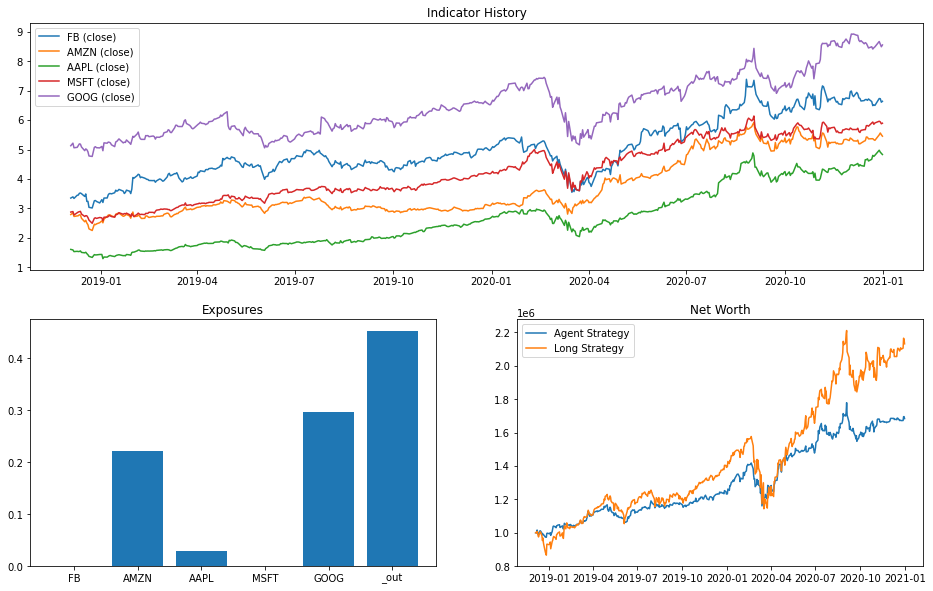

In [20]:
for episode in np.arange(1):

    done = False
    obs = env.reset()

    while not done:
            
        agent_obs = predictor.predict(obs)

        action = agent.select_action(agent_obs)
        action_fmt = env.format_action(positions, action)

        new_obs, reward, done, info = env.step(action_fmt)
        
        obs = new_obs

        env.render()
    
        reward_trace['rewards'].append(reward)
        reward_trace['actions'].append(action.squeeze())
        reward_trace['net_worth_diff'].append(env.net_worth[-1]-env.net_worth_long[-1])
        reward_trace['profit_diff'].append(env.agent_portfolio.profits[-1]-env.long_portfolio.profits[-1])
    

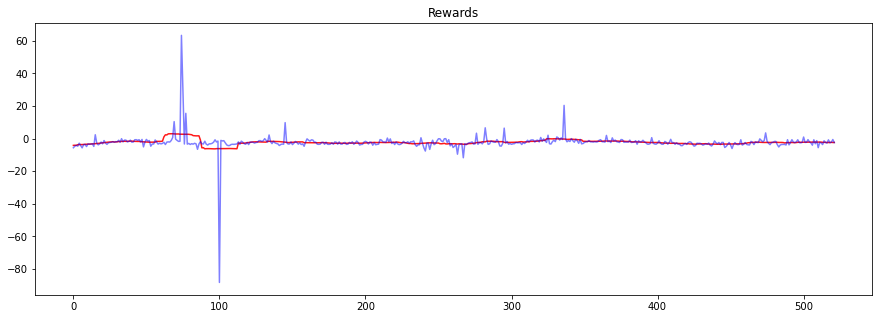

In [21]:
rewards = pd.Series(reward_trace['rewards']).rolling(window=25, center=True, min_periods=1).mean()

plt.figure(figsize=(15,5))

plt.plot(rewards.values, 'r', alpha=0.9)
plt.plot(reward_trace['rewards'], 'b', alpha=0.5)

plt.title('Rewards')
plt.show()

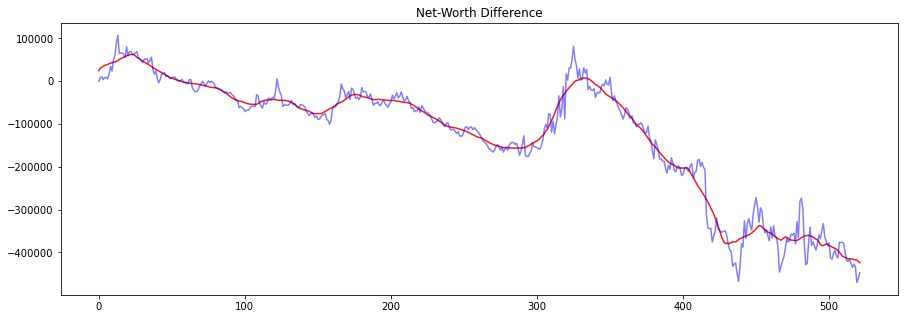

In [22]:
net_worth = pd.Series(reward_trace['net_worth_diff']).rolling(window=25, center=True, min_periods=1).mean()

plt.figure(figsize=(15,5))

plt.plot(net_worth.values, 'r', alpha=0.9)
plt.plot(reward_trace['net_worth_diff'], 'b', alpha=0.5)

plt.title('Net-Worth Difference')
plt.show()

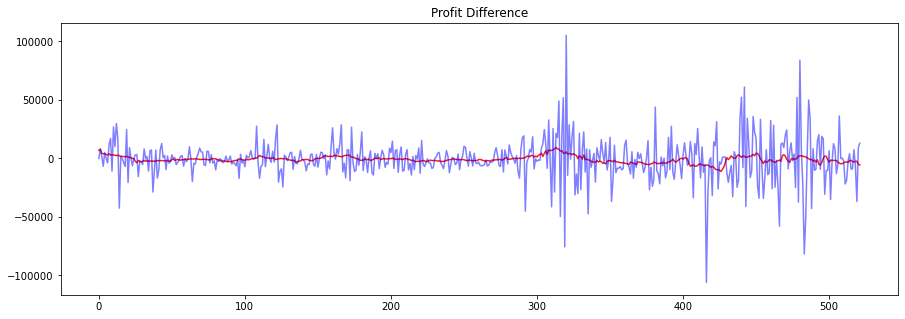

In [23]:
profit = pd.Series(reward_trace['profit_diff']).rolling(window=25, center=True, min_periods=1).mean()

plt.figure(figsize=(15,5))

plt.plot(profit.values, 'r', alpha=0.9)
plt.plot(reward_trace['profit_diff'], 'b', alpha=0.5)

plt.title('Profit Difference')
plt.show()

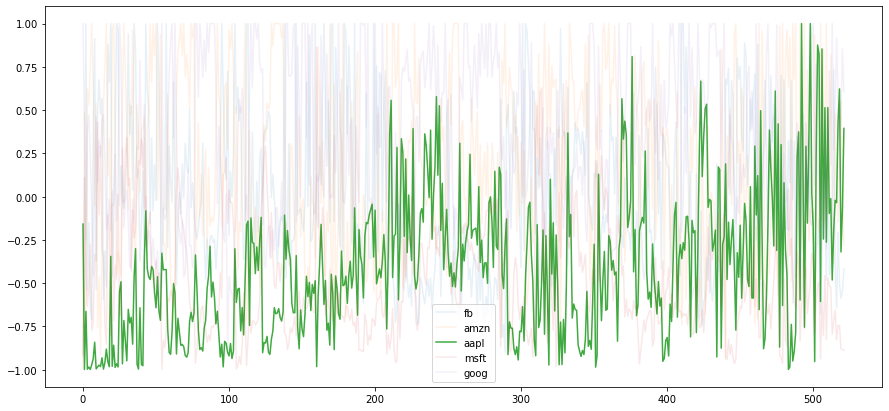

In [27]:
stock = 'aapl'

plt.figure(figsize=(15,7))

actions = np.array(reward_trace['actions'])
for action, ticker in zip(actions[:, : env.n_stocks].T, positions):
    a = 0.9 if ticker == stock else 0.1
    plt.plot(action, label=ticker, alpha=a)
    
plt.legend()
plt.show()